# 人脸年龄检测

在接下来的案例中，我们将对照片中的人像进行识别并进行年龄检测。识别图像中的人像使用了MTCNN模型，年龄预测部分使用了SSR模型。

MTCNN模型可以通过`pip`安装之后调用Python API进行方法使用，也可以构建模型，加载预训练权重进行调用。这两种方法我们都将进行介绍。

### 进入ModelArts

点击如下链接：https://www.huaweicloud.com/product/modelarts.html ， 进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。

### 创建ModelArts notebook

下面，我们在ModelArts中创建一个notebook开发环境，ModelArts notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![create_nb_create_button](./img/create_nb_create_button.png)

第二步：填写notebook所需的参数：

|项目|建议填写方式|
|-|-|
|名称|自定义环境名称|
|工作环境 | Python3|
| 资源池 | 选择"公共资源池"即可 |
|类型|GPU|
|规格|GPU:1*p100, CPU:8核64GiB|
|存储配置|EVS|
|磁盘规格|5GB|

第三步：配置好notebook参数后，点击下一步，进入notebook信息预览。确认无误后，点击“立即创建”

![create_nb_creation_summary](./img/create_nb_creation_summary.png)

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。
![modelarts_notebook_index](./img/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境

接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![inter_dev_env](img/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的"New"，然后选择TensorFlow 1.13.1开发环境。

第三步：点击左上方的文件名"Untitled"，并输入一个与本实验相关的名称，如"age_prediction"
![notebook_untitled_filename](./img/notebook_untitled_filename.png)
![notebook_name_the_ipynb](./img/notebook_name_the_ipynb.png)


### 在Notebook中编写并执行代码

在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./img/run_helloworld.png)


开发环境准备好啦，接下来可以愉快地写代码啦！

### 数据和代码下载
运行下面代码，进行数据和代码的下载和解压


In [ ]:
from modelarts.session import Session
sess = Session()

if sess.region_name == 'cn-north-1':
    bucket_path="modelarts-labs/notebook/DL_face_age_prediction/ssr.tar"
elif sess.region_name == 'cn-north-4':
    bucket_path="modelarts-labs-bj4/notebook/DL_face_age_prediction/ssr.tar"
else:
    print("请更换地区到北京一或北京四")

sess.download_data(bucket_path=bucket_path, path="./ssr.tar")

# 案例内容

In [ ]:
!tar -xf ssr.tar

准备环境：安装`mtcnn`。

In [12]:
!pip install mtcnn==0.0.8

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import random
from PIL import Image

测试图片通过网页`upload`上传，图片路径存储在`image_path`中。可以这里我们提供了一张测试图片，可以上传自己的图片进行测试。

In [14]:
image_path = "./test.jpeg"
img = Image.open(image_path)
img = np.array(img)

检测结果为：

In [15]:
# 直接调用和使用MTCNN方法，简洁快速。
from mtcnn.mtcnn import MTCNN as mtcnn
detector = mtcnn()
detected = detector.detect_faces(img)
detected

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


[{'box': [196, 52, 108, 158],
  'confidence': 0.9999769926071167,
  'keypoints': {'left_eye': (222, 115),
   'right_eye': (273, 120),
   'nose': (239, 151),
   'mouth_left': (217, 166),
   'mouth_right': (268, 171)}}]

将检测结果绘制在图片上：

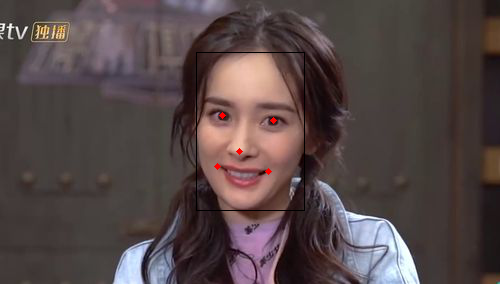

In [16]:
# 绘图部分
box = detected[0]["box"]
res_img = cv2.rectangle(img, (box[0],box[1]),(box[0]+box[2],box[1]+box[3]), 0, 1)

keypoints = detected[0]["keypoints"]
res_img = cv2.circle(res_img, keypoints['left_eye'], 1, 255, 4)
res_img = cv2.circle(res_img, keypoints['right_eye'], 1, 255, 4)
res_img = cv2.circle(res_img, keypoints['nose'], 1, 255, 4)
res_img = cv2.circle(res_img, keypoints['mouth_left'], 1, 255, 4)
res_img = cv2.circle(res_img, keypoints['mouth_right'], 1, 255, 4)

res_img = Image.fromarray(res_img)
res_img

In [1]:
from src.align.detect_face import Network
from src.align.detect_face import rerec, pad
from src.align.detect_face import nms
from src.align.detect_face import imresample
from src.align.detect_face import generateBoundingBox

##### PNet
全称为proposal network， 负责检测出人脸可能出现的位置，并进行nms和边界框回归，对人脸区域进行筛选。
PNet构建代码如下所示：

In [2]:
class PNet(Network):
    def setup(self):
        (self.feed('data') 
             .conv(3, 3, 10, 1, 1, padding='VALID', relu=False, name='conv1')
             .prelu(name='PReLU1')
             .max_pool(2, 2, 2, 2, name='pool1')
             .conv(3, 3, 16, 1, 1, padding='VALID', relu=False, name='conv2')
             .prelu(name='PReLU2')
             .conv(3, 3, 32, 1, 1, padding='VALID', relu=False, name='conv3')
             .prelu(name='PReLU3')
             .conv(1, 1, 2, 1, 1, relu=False, name='conv4-1')
             .softmax(3,name='prob1'))

        (self.feed('PReLU3') 
             .conv(1, 1, 4, 1, 1, relu=False, name='conv4-2'))

##### RNet
全称为Refine Network，将PNet的结果作为输入的一部分，对PNet检测出的结果进行进一步筛选。
RNet构建代码如下所示：

In [3]:
class RNet(Network):
    def setup(self):
        (self.feed('data') #pylint: disable=no-value-for-parameter, no-member
             .conv(3, 3, 28, 1, 1, padding='VALID', relu=False, name='conv1')
             .prelu(name='prelu1')
             .max_pool(3, 3, 2, 2, name='pool1')
             .conv(3, 3, 48, 1, 1, padding='VALID', relu=False, name='conv2')
             .prelu(name='prelu2')
             .max_pool(3, 3, 2, 2, padding='VALID', name='pool2')
             .conv(2, 2, 64, 1, 1, padding='VALID', relu=False, name='conv3')
             .prelu(name='prelu3')
             .fc(128, relu=False, name='conv4')
             .prelu(name='prelu4')
             .fc(2, relu=False, name='conv5-1')
             .softmax(1,name='prob1'))

        (self.feed('prelu4') #pylint: disable=no-value-for-parameter
             .fc(4, relu=False, name='conv5-2'))

##### ONet 
全称为Output Network，作为最后一层网络，将输出人脸区域坐标以及人脸关键点坐标。
ONet构建代码如下所示：

In [4]:
class ONet(Network):
    def setup(self):
        (self.feed('data') #pylint: disable=no-value-for-parameter, no-member
             .conv(3, 3, 32, 1, 1, padding='VALID', relu=False, name='conv1')
             .prelu(name='prelu1')
             .max_pool(3, 3, 2, 2, name='pool1')
             .conv(3, 3, 64, 1, 1, padding='VALID', relu=False, name='conv2')
             .prelu(name='prelu2')
             .max_pool(3, 3, 2, 2, padding='VALID', name='pool2')
             .conv(3, 3, 64, 1, 1, padding='VALID', relu=False, name='conv3')
             .prelu(name='prelu3')
             .max_pool(2, 2, 2, 2, name='pool3')
             .conv(2, 2, 128, 1, 1, padding='VALID', relu=False, name='conv4')
             .prelu(name='prelu4')
             .fc(256, relu=False, name='conv5')
             .prelu(name='prelu5')
             .fc(2, relu=False, name='conv6-1')
             .softmax(1, name='prob1'))

        (self.feed('prelu5') #pylint: disable=no-value-for-parameter
             .fc(4, relu=False, name='conv6-2'))

        (self.feed('prelu5') #pylint: disable=no-value-for-parameter
             .fc(10, relu=False, name='conv6-3'))

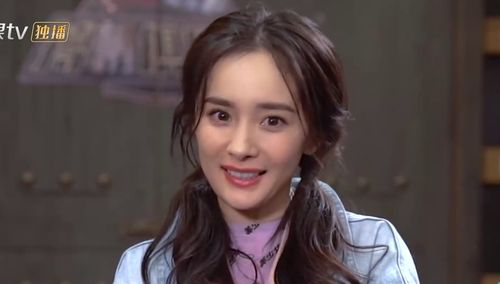

In [5]:
test_img = Image.open(image_path)
test_img

In [6]:
# 进行图片预处理
test_img = np.array(test_img)
img_size = np.asarray(test_img.shape)[0:2]
factor_count=0
minsize = 20
total_boxes=np.empty((0,9))
points=np.empty(0)
h=test_img.shape[0] # h=410
w=test_img.shape[1] # w=599

minl=np.amin([h, w]) # minl = [410,599] 中最小值 410
m=12.0/minsize # m=12/20
minl=minl*m # minl = 410*12/20 = 410* 0.6 
factor = 0.709 
scales=[]

while minl>=12:
    scales += [m*np.power(factor, factor_count)]
    minl = minl*factor 
    factor_count += 1

# first stage
for scale in scales:
    hs=int(np.ceil(h*scale)) #大于等于该值的最小整数
    ws=int(np.ceil(w*scale))
    im_data = cv2.resize(test_img, (ws, hs), interpolation=cv2.INTER_AREA)
    im_data = (im_data-127.5)*0.0078125
    img_x = np.expand_dims(im_data, 0)
    img_y = np.transpose(img_x, (0,2,1,3))

In [7]:
# 构建网络，加载预训练权重。
with tf.Graph().as_default():
    with tf.Session() as sess:
        with tf.variable_scope('pnet'):
            data = tf.placeholder(tf.float32, shape=(None, None, None, 3), name="input")
            pnet = PNet({'data':data})
            pnet.load("./src/align/PNet.npy", sess)
            out = sess.run(('pnet/conv4-2/BiasAdd:0', 'pnet/prob1:0'), feed_dict={'pnet/input:0':img_y})
            
#  boundingbox regression 结果 
out0 = np.transpose(out[0], (0,2,1,3))
#  face classification 结果
out1 = np.transpose(out[1], (0,2,1,3))

threshold = 0.5
boxes, reg = generateBoundingBox(out1[0,:,:,1].copy(), out0[0,:,:,:].copy(), scale, threshold)
print("PNet产生结果为："+str(boxes.shape))
            
total_boxes = boxes.copy()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
PNet产生结果为：(8, 9)


In [8]:
# 边界框绘制函数
def draw_bboxes(img, total_boxes):
   
    for i in range(total_boxes.shape[0]):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)

        x1 = int(total_boxes[:,0][i])
        y1 =  int(total_boxes[:,1][i])
        x2=  int(total_boxes[:,2][i])
        y2 =  int(total_boxes[:,3][i])

        img = cv2.rectangle(img,(x1,y1),(x2,y2), (r,g,b), 2)
    
    return img

将预测结果进行筛选和回归，计算后的结果绘制在图片上。

筛选之后结果为：(8, 9)
(4, 9)
(4, 5)
[[182.05924197  70.7716465  346.76112445 235.47352898   0.99946338]
 [163.05917448  54.30253755 346.4910142  237.73437726   0.99873585]
 [169.00709138  35.51472241 362.24307533 228.75070636   0.9966929 ]
 [156.12690619  55.94950742 365.15729818 264.97989941   0.94242734]]
[[182.          70.         346.         235.           0.99946338]
 [163.          54.         346.         237.           0.99873585]
 [169.          35.         362.         228.           0.9966929 ]
 [156.          55.         365.         264.           0.94242734]]


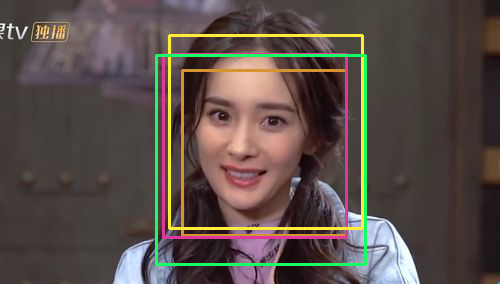

In [9]:
img = Image.open(IMAGE_PATH)
img = np.array(img)
Image.fromarray(draw_bboxes(img,total_boxes))
total_boxes=np.empty((0,9))
pick = nms(boxes.copy(), 0.7, 'Union')

if boxes.size>0 and pick.size>0:
    boxes = boxes[pick,:]
    total_boxes = np.append(total_boxes, boxes, axis=0)
print("筛选之后结果为："+str(total_boxes.shape))
# 绘制筛选后的边界框
img = Image.open(IMAGE_PATH)
img = np.array(img)

# 进行nms计算 参数为0.7
pick = nms(total_boxes.copy(), 0.6, 'Union')
total_boxes = total_boxes[pick,:]
print(total_boxes.shape)

# 边界框回归
regw = total_boxes[:,2]-total_boxes[:,0]
regh = total_boxes[:,3]-total_boxes[:,1]
qq1 = total_boxes[:,0]+total_boxes[:,5]*regw
qq2 = total_boxes[:,1]+total_boxes[:,6]*regh
qq3 = total_boxes[:,2]+total_boxes[:,7]*regw
qq4 = total_boxes[:,3]+total_boxes[:,8]*regh
total_boxes = np.transpose(np.vstack([qq1, qq2, qq3, qq4, total_boxes[:,4]]))
print(total_boxes.shape)
img = Image.open(IMAGE_PATH)
img = np.array(img)

# 将边界框形状转为正方形
total_boxes = rerec(total_boxes.copy())
print(total_boxes)

# 将边界框坐标整理成整数
total_boxes[:,0:4] = np.fix(total_boxes[:,0:4]).astype(np.int32)
print(total_boxes)
dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph = pad(total_boxes.copy(), w, h)
img = Image.open(IMAGE_PATH)
img = np.array(img)
Image.fromarray(draw_bboxes(img,total_boxes))


MTCNN的PNet计算结束后，可以看到已经有若干个边界框已经被预测出来。接下来我们将进行RNet预测，通过RNet预测之后，边界框将更加准确。

[[169.          35.         362.         228.           0.99657506]
 [182.          70.         346.         235.           0.99317247]]
[[187.88260472  50.3101214  304.03469801 207.99129453   0.99657506]
 [191.52215174  59.21930605 301.22840619 201.50423944   0.99317247]]
[[167.1180648   50.3101214  324.79923793 207.99129453   0.99657506]
 [175.23281227  59.21930605 317.51774566 201.50423944   0.99317247]]


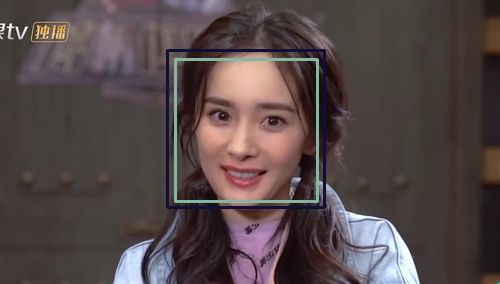

In [10]:
numbox = total_boxes.shape[0] 
tempimg = np.zeros((24,24,3,numbox))
for k in range(0,numbox):
    tmp = np.zeros((int(tmph[k]),int(tmpw[k]),3))
    tmp[dy[k]-1:edy[k],dx[k]-1:edx[k],:] = img[y[k]-1:ey[k],x[k]-1:ex[k],:]
    if tmp.shape[0]>0 and tmp.shape[1]>0 or tmp.shape[0]==0 and tmp.shape[1]==0:
        tempimg[:,:,:,k] = imresample(tmp, (24, 24))
    else:
        print(0)
tempimg = (tempimg-127.5)*0.0078125
tempimg1 = np.transpose(tempimg, (3,1,0,2))
with tf.Graph().as_default():
    with tf.Session() as sess:
        with tf.variable_scope('rnet'):
            data = tf.placeholder(tf.float32, shape=(None, 24, 24, 3), name="input")
            rnet = RNet({'data':data})
            rnet.load("./src/align/RNet.npy", sess)
            out = sess.run(('rnet/conv5-2/conv5-2:0', 'rnet/prob1:0'), feed_dict={'rnet/input:0':tempimg1})
            
# 检测到的人脸坐标
out0 = np.transpose(out[0])
out1 = np.transpose(out[1])

score = out1[1,:]
threshold = 0.7
ipass = np.where(score>0.2)
total_boxes = np.hstack([total_boxes[ipass[0],0:4].copy(), np.expand_dims(score[ipass].copy(),1)])
mv = out0[:,ipass[0]]
if total_boxes.shape[0]>0:
    pick = nms(total_boxes, threshold, 'Union')
    total_boxes = total_boxes[pick,:]
    print(total_boxes)

img = Image.open(IMAGE_PATH)
img = np.array(img)
    
from src.align.detect_face import bbreg
# 边界框回归
total_boxes = bbreg(total_boxes.copy(), np.transpose(mv[:,pick]))
print(total_boxes)
# 边界框整理成正方形
total_boxes = rerec(total_boxes.copy())
print(total_boxes)

img = Image.open(IMAGE_PATH)
img = np.array(img)
Image.fromarray(draw_bboxes(img,total_boxes))

最后，我们进行ONet预测，不仅使人脸的边界框检测更加准确，这一步还将关键点检测出来。

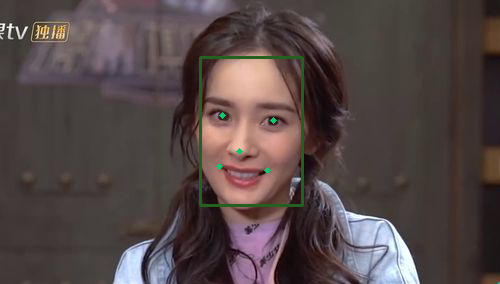

In [11]:
numbox = total_boxes.shape[0]
total_boxes = np.fix(total_boxes).astype(np.int32)
dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph = pad(total_boxes.copy(), w, h)

tempimg = np.zeros((48,48,3,numbox))
for k in range(0,numbox):
    tmp = np.zeros((int(tmph[k]),int(tmpw[k]),3))
    tmp[dy[k]-1:edy[k],dx[k]-1:edx[k],:] = img[y[k]-1:ey[k],x[k]-1:ex[k],:]
    if tmp.shape[0]>0 and tmp.shape[1]>0 or tmp.shape[0]==0 and tmp.shape[1]==0:
        tempimg[:,:,:,k] = imresample(tmp, (48, 48))
    else:
        print(0)
tempimg = (tempimg-127.5)*0.0078125
tempimg1 = np.transpose(tempimg, (3,1,0,2))
with tf.Graph().as_default():
    with tf.Session() as sess:
        with tf.variable_scope('onet'):
            data = tf.placeholder(tf.float32, shape=(None, 48, 48, 3), name="input")
            onet = ONet({'data':data})
            rnet.load("./src/align/ONet.npy", sess)
            out = sess.run(('onet/conv6-2/conv6-2:0', 'onet/conv6-3/conv6-3:0', 'onet/prob1:0'), feed_dict={'onet/input:0':tempimg1})
            
# 人脸区域边界框预测结果
out0 = np.transpose(out[0])
# 人脸关键点预测结果
out1 = np.transpose(out[1])
# 人脸区域置信度
out2 = np.transpose(out[2])

score = out2[1,:]
points = out1
# threshold = 0.7
ipass = np.where(score>0.7)
points = points[:,ipass[0]]
total_boxes = np.hstack([total_boxes[ipass[0],0:4].copy(), np.expand_dims(score[ipass].copy(),1)])
mv = out0[:,ipass[0]]

w = total_boxes[:,2]-total_boxes[:,0]+1
h = total_boxes[:,3]-total_boxes[:,1]+1
points[0:5,:] = np.tile(w,(5, 1))*points[0:5,:] + np.tile(total_boxes[:,0],(5, 1))-1
points[5:10,:] = np.tile(h,(5, 1))*points[5:10,:] + np.tile(total_boxes[:,1],(5, 1))-1
if total_boxes.shape[0]>0:
    total_boxes = bbreg(total_boxes.copy(), np.transpose(mv))
    pick = nms(total_boxes.copy(), 0.7, 'Min')
    total_boxes = total_boxes[pick,:]
    points = points[:,pick]
img = Image.open(IMAGE_PATH)
img = np.array(img)

r = random.randint(0, 255)
g = random.randint(0, 255)
b = random.randint(0, 255)

point_color = (r, g, b) 

for i in range(5):
    cv2.circle(img,(int(points[i]),int(points[i+5])),1, point_color, 4)
    
Image.fromarray(draw_bboxes(img,total_boxes))

##### SSR 模型

首先我们将模型结构和权重加载，预训练模型位置存储在`weight_file`中。

In [19]:
from SSRNET_model import SSR_net

weight_file = "./ssrnet_3_3_3_64_1.0_1.0.h5"

img_size = 64
stage_num = [3,3,3]
lambda_local = 1
lambda_d = 1
model = SSR_net(img_size,stage_num, lambda_local, lambda_d)()
model.load_weights(weight_file)

Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


模型层级结构

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 62, 62, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 62, 62, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 62, 62, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
batch_norm

准备输入数据

In [21]:
faces = np.empty((len(detected), img_size, img_size, 3))
faces.shape

(1, 64, 64, 3)

将图片的大小进行调整，图片根据人脸检测结果进行裁剪和缩放。

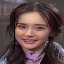

In [22]:
ad = 0.4

img_h, img_w, _ = np.shape(img)

for i,d in enumerate(detected):
    if d['confidence'] >=0.95 :
        x1,y1,w,h = d['box']
        x2 = x1 + w
        y2 = y1 + h
        xw1 = max(int(x1 - ad * w), 0)
        yw1 = max(int(y1 - ad * h), 0)
        xw2 = min(int(x2 + ad * w), img_w - 1)
        yw2 = min(int(y2 + ad * h), img_h - 1)
        img = cv2.resize(img[yw1:yw2+1, xw1:xw2+1, :], (img_size, img_size))
        faces[i,:,:,:] = img
        
res_img = Image.fromarray(img)
res_img


将输入数据输入模型，获得预测结果：

In [23]:
res = model.predict(faces)

In [24]:
print("预测年龄为："+str(int(res[0])))

预测年龄为：23
